In [30]:
path = "C:/Users/Yakina/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1/flickr30k_images/"
import os
os.listdir(path)

['flickr30k_images', 'results.csv']

In [31]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [32]:
image_path = path + 'flickr30k_images/'
csv_path = path + 'results.csv'

In [33]:
data = pd.read_csv(csv_path, sep = r'\s*\|\s*')
data.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"Two young , White males are outside near many ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [34]:
data['image_name'] = data['image_name'].astype(str)
data['comment_number'] = data['comment_number'].astype(int)
data['comment'] = data['comment'].astype(str)

In [35]:
data.dtypes

image_name        object
comment_number     int64
comment           object
dtype: object

In [36]:
data.isnull().sum()

image_name        0
comment_number    0
comment           0
dtype: int64

In [37]:
def readImage(path, img_size = 224):
    img = load_img(path, color_mode = 'rgb', target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(image_path + temp_df.image_name[i])
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.comment[i], 20)))
        plt.axis("off")

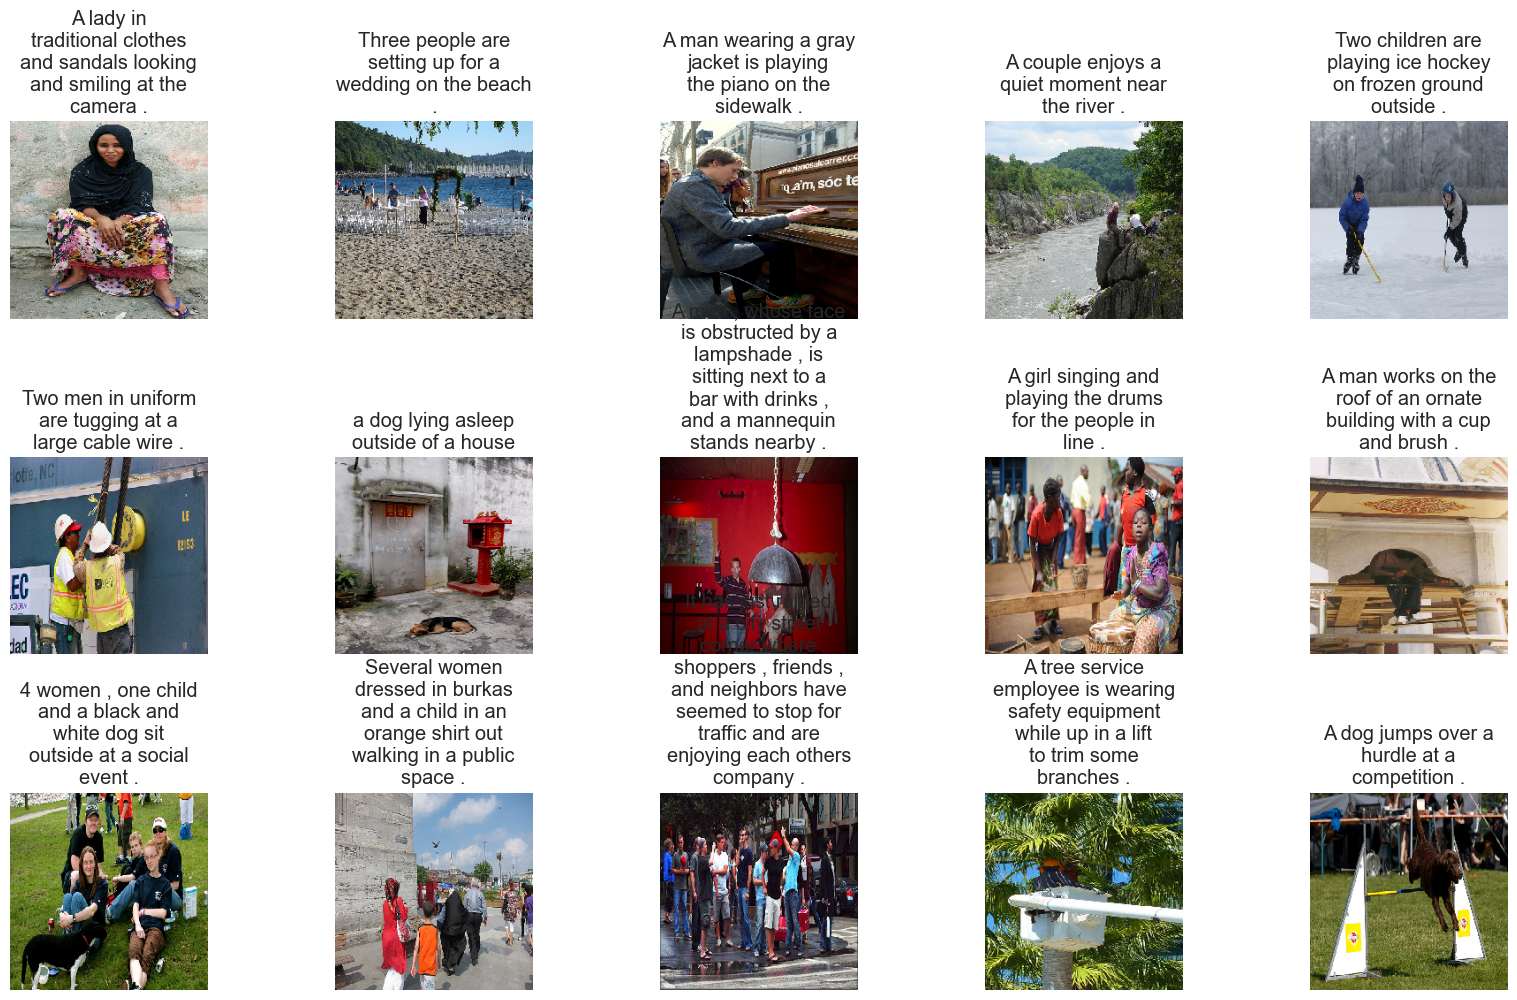

In [38]:
display_images(data.sample(15))

In [39]:
def text_preprocessing(data):
    data['comment'] = data['comment'].apply(lambda x: x.lower())
    data['comment'] = data['comment'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['comment'] = data['comment'].apply(lambda x: x.replace("\s+"," "))
    data['comment'] = data['comment'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['comment'] = "startseq " + data['comment'] + " endseq"
    return data

In [40]:
data = text_preprocessing(data)
captions = data['comment'].tolist()
captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image_name'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image_name'].isin(train_images)]
test = data[data['image_name'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 12, 21, 20, 708, 13, 54, 79, 194, 1421, 2]

In [43]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image_name'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 31783/31783 [2:30:25<00:00,  3.52it/s]  


In [44]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [45]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
# caption_model.compile(loss='categorical_crossentropy',optimizer='adam')
caption_model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])

In [49]:
from tensorflow.keras.utils import plot_model

In [51]:
plot_model(caption_model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [52]:
caption_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 74)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 74, 256)   │  4,688,128 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 75, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 18313)     │  2,362,377 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,100,489 (30.90 MB)

 Trainable params: 8,100,489 (30.90 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
train_generator = CustomDataGenerator(df = train, X_col = 'image_name', y_col = 'comment', batch_size = 64,directory = image_path, tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_length, features = features)

validation_generator = CustomDataGenerator(df = test, X_col = 'image_name', y_col = 'comment', batch_size = 64, directory = image_path,  tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_length, features = features)

In [57]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor = "val_loss",
                            mode = "min",
                            save_best_only = True,
                            verbose = 1)

earlystopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', 
                                            patience = 3, 
                                            verbose = 1, 
                                            factor = 0.2, 
                                            min_lr = 0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs = 50,
        validation_data = validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction])

Epoch 1/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1674 - loss: 5.4109
Epoch 1: val_loss improved from inf to 4.55298, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 6998s 3s/step - accuracy: 0.1674 - loss: 5.4106 - val_accuracy: 0.2330 - val_loss: 4.5530 - learning_rate: 0.0010
Epoch 2/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2486 - loss: 4.3419
Epoch 2: val_loss improved from 4.55298 to 4.29409, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 11833s 6s/step - accuracy: 0.2486 - loss: 4.3419 - val_accuracy: 0.2545 - val_loss: 4.2941 - learning_rate: 0.0010
Epoch 3/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2644 - loss: 4.1242
Epoch 3: val_loss improved from 4.29409 to 4.19563, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 5507s 3s/step - accuracy: 0.2644 - loss: 4.1242 - val_accuracy: 0.2629 - val_loss: 4.1956 - learning_rate: 0.0010
Epoch 4/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2712 - loss: 4.0066
Epoch 4: val_loss improved from 4.19563 to 4.13708, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 5644s 3s/step - accuracy: 0.2712 - loss: 4.0066 - val_accuracy: 0.2684 - val_loss: 4.1371 - learning_rate: 0.0010
Epoch 5/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2771 - loss: 3.9275
Epoch 5: val_loss improved from 4.13708 to 4.11473, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 5652s 3s/step - accuracy: 0.2771 - loss: 3.9275 - val_accuracy: 0.2722 - val_loss: 4.1147 - learning_rate: 0.0010
Epoch 6/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2810 - loss: 3.8660
Epoch 6: val_loss improved from 4.11473 to 4.10311, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 5654s 3s/step - accuracy: 0.2810 - loss: 3.8660 - val_accuracy: 0.2744 - val_loss: 4.1031 - learning_rate: 0.0010
Epoch 7/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2845 - loss: 3.8122
Epoch 7: val_loss improved from 4.10311 to 4.08072, saving model to model.h5


2110/2110 ━━━━━━━━━━━━━━━━━━━━ 5651s 3s/step - accuracy: 0.2845 - loss: 3.8122 - val_accuracy: 0.2766 - val_loss: 4.0807 - learning_rate: 0.0010
Epoch 8/50
1465/2110 ━━━━━━━━━━━━━━━━━━━━ 26:14 2s/step - accuracy: 0.2864 - loss: 3.7698